In [1]:
import eda
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as matp
import matplotlib.gridspec as gridspec
import re, gc, pickle, json
import configuration as configuration


from tqdm.auto import tqdm
from transformers import AutoTokenizer
from wordcloud import WordCloud, STOPWORDS
from typing import List, Tuple, Dict, Callable, Any
from preprocessing import jsonl_to_json, load_all_types_dataset, stratified_kfold, check_null, null2str, sequence_length
%matplotlib inline

In [2]:
df = pd.read_csv('./data_folder/commerce/amazon/meta_grocery_gourmet_food_asin_db.csv')
df

,main_category,title,average_rating,features,description,price,categories,details,asin,sub_category
0,Grocery & Gourmet Food,Dark Roast Pure Coffee,4.7,[],[],NaN,"['Beverages', 'Coffee']","{'Brand': 'Luzianne', 'Item Form': 'Ground', '...",B00NE08WM6,Beverages
1,Grocery & Gourmet Food,PICARAS Galletas Peruanas Bañadas en Chocolate...,4.5,['2 Bags of PICARAS Galletas Bañadas en Chocol...,['2 Bags of PICARAS Galletas Bañadas en Chocol...,15.99,"['Breads & Bakery', 'Cookies', 'Chocolate']","{'Flavor': 'chocolate', 'Unit Count': '12.00 C...",B084Q13Q5Q,Breads & Bakery
2,Grocery & Gourmet Food,Chipped Beef and Gravy By Patterson's - Great ...,3.2,['Six (6) 8-ounce cans of delicious chipped be...,"[""Delicious corned beef gravy is ready when yo...",NaN,"['Pantry Staples', 'Canned, Jarred & Packaged ...",{'Package Dimensions': '8.4 x 5.8 x 3.4 inches...,B00KBRUYVM,Pantry Staples
3,Grocery & Gourmet Food,Asher's Sugar Free Milk Chocolate Cordial Cher...,5.0,[],[],29.99,"['Snacks & Sweets', 'Chocolate', 'Fruit']","{'Brand': 'Generic', 'Item Form': 'Ball', 'Cho...",B0BN4PW255,Snacks & Sweets
4,Grocery & Gourmet Food,Messmer Peppermint 25 bags (6er pack),3.5,[],[],29.99,[],"{'Brand': 'Messmer', 'Item Form': 'Teabags', '...",B06X9DC27H,etc
...,...,...,...,...,...,...,...,...,...,...
540008,Grocery & Gourmet Food,LVEUD Happy Birthday Cake Topper Black Font Go...,5.0,[],[],NaN,"['Pantry Staples', 'Cooking & Baking', 'Frosti...","{'Is Discontinued By Manufacturer': 'No', 'Pro...",B07NJV1FMQ,Pantry Staples
540009,Grocery & Gourmet Food,Sugar Free Hard Candy Factor Zero Espresso Cof...,5.0,[],[],NaN,[],{'Package Dimensions': '8.9 x 7.83 x 2.91 inch...,B07RS4F1J4,etc
540010,Grocery & Gourmet Food,"Tre Mulini: ""Mezze Penne Rigate"" Durum Wheat S...",5.0,['Pasta made of first quality 100% durum semol...,"['Pasta is a staple of Mediterranean diet, tha...",NaN,"['Pantry Staples', 'Pasta & Noodles', 'Pasta',...","{'Brand': 'Tre Mulini', 'Variety': 'Penne Riga...",B00KLF7I1S,Pantry Staples
540011,Grocery & Gourmet Food,KaBloom PRIME NEXT DAY DELIVERY - 12 Fresh Pur...,3.2,[],['This cheerful bouquet of fresh cut purple ro...,39.24,[],"{'Brand': 'KaBloom', 'Color': 'Purple', 'Numbe...",B071F3LMGC,etc


In [6]:
df.sub_category.value_counts()

Pantry Staples                              172245
Snacks & Sweets                             103767
Beverages                                    87577
etc                                          68198
Breads & Bakery                              24309
                                             ...  
Lindt Easter Candy                               1
Quick school night dinners                       1
Union Kitchen                                    1
Scharffen Berger Holiday                         1
Gevalia, McCafe and Maxwell House Coffee         1
Name: sub_category, Length: 324, dtype: int64

In [2]:
""" Merge Two different categories of dataset in amazon review data """

beauty_df, fashion_df = load_all_types_dataset('./data_folder/amazon_review/beauty.json'), load_all_types_dataset('./data_folder/amazon_review/fashion.json')
beauty_df['domain'], fashion_df['domain'] = 'beauty', 'fashion'
df = pd.concat([beauty_df, fashion_df], axis=0).reset_index(drop=True)
df = stratified_kfold(df, 'rating', configuration.CFG)
df.to_csv('train.csv', index=False, encoding='utf-8')

In [2]:
df = load_all_types_dataset('./data_folder/commerce/amazon/train.csv')
df

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,domain,fold
0,5,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923,0,True,beauty,3
1,4,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.070,1,True,beauty,1
2,5,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052,2,True,beauty,7
3,1,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220,0,True,beauty,5
4,5,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.534,0,True,beauty,3
...,...,...,...,...,...,...,...,...,...,...,...,...
3202462,5,... allowed them to be used to add military ri...,The tie tacks were the size that allowed them ...,[],B00YGFMQC0,B00YGFMQC0,AFXSFD3FTZ2CLN3TYV4B63CQM5BQ,2016-06-24 20:12:38.000,0,True,fashion,3
3202463,1,Didn’t come with all ten,Says ten tie clips but o only received 7.,[],B00YGFMQC0,B00YGFMQC0,AEH7WP5HGM6FGLSSC6GSTYUXBHGQ,2018-05-08 17:05:05.585,0,True,fashion,3
3202464,3,Not checked for quality,When I received them 2-3 of them did not open ...,[],B00YGFMQC0,B00YGFMQC0,AEL2TSSBVLIPWQ7YVMK364DUYURQ,2016-12-17 22:28:31.000,0,True,fashion,7
3202465,5,Awesome,Great product.,[],B00YGFMQC0,B00YGFMQC0,AGZ6IIYSPCW4YXWH6VFEOI7MTBZA,2017-04-15 17:34:26.000,1,True,fashion,0


In [3]:
""" Null Checker Function """

df = null2str(df)
check_null(df)

rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
domain               0
fold                 0
dtype: int64

In [3]:
df['length'] = sequence_length(configuration.CFG, df['text'])

  0%|          | 0/3202467 [00:00<?, ?it/s]

TypeError: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]

In [2]:
""" configuration for preprocessing and eda """


class CFG:
    seed = 42
    tokenizer_name = 'microsoft/deberta-v3-large'  # later, remove this line
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    max_len = 512
    split_ratio = 0.2
    n_folds = 5

In [3]:
""" Helper Function for preprocessing """

def group_texts(cfg: configuration.CFG, sequences: Dict) -> Dict:
    """ Dealing Problem: some of data instances are longer than the maximum input length for the model,
    This function is ONLY used to HF Dataset Object

    1) Concatenate all texts
    2) We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    3) customize this part to your needs
    4) Split by chunks of max_len

    """
    concatenated_sequences = {k: sum(sequences[k], []) for k in sequences.keys()}
    total_length = len(concatenated_sequences[list(sequences.keys())[0]])
    if total_length >= cfg.max_seq:
        total_length = (total_length // cfg.max_seq) * cfg.max_seq
    result = {
        k: [t[i: i + cfg.max_seq] for i in range(0, total_length, cfg.max_seq)]
        for k, t in concatenated_sequences.items()
    }
    return result

def tokenizing(cfg: configuration.CFG, text: str, padding: bool or str = 'max_length') -> Any:
    """ Preprocess text for LLM Input, for common batch system

    Args:
        cfg: configuration.CFG, needed to load tokenizer from Huggingface AutoTokenizer
        text: text from dataframe or any other dataset, please pass str type
        padding: padding options, default 'max_length', if you want use smart batching, init this param to False
    """
    inputs = cfg.tokenizer.encode_plus(
        text,
        max_length=cfg.max_len,
        padding=padding,
        truncation=False,
        return_tensors=None,
        add_special_tokens=False,  # later, we will add ourselves
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v)
    return inputs

def adjust_sequences(sequences: List, max_len: int):
    """ Similar to dynamic padding concept
    Append slicing index from original, because original source code is implemented weired
    So it generates some problem for applying very longer sequence
    Add -1 value to slicing index, so we can get result what we want

    Args:
        sequences: list of each cell's token sequence in one unique notebook id, must pass tokenized sequence input_ids
        => sequences = [[1,2,3,4,5,6], [1,2,3,4,5,6], ... , [1,2,3,4,5]]
        max_len: max length of sequence into LLM Embedding Layer, default is 2048 for DeBERTa-V3-Large

    Reference:
         https://github.com/louis-she/ai4code/blob/master/ai4code/utils.py#L70
    """
    length_of_seqs = [len(seq) for seq in sequences]
    total_len = sum(length_of_seqs)
    cut_off = total_len - max_len
    if cut_off <= 0:
        return sequences, length_of_seqs

    for _ in range(cut_off):
        max_index = length_of_seqs.index(max(length_of_seqs))
        length_of_seqs[max_index] -= 1
    sequences = [sequences[i][:l-1] for i, l in enumerate(length_of_seqs)]
    return sequences, length_of_seqs

def subsequent_tokenizing(cfg: configuration.CFG, text: str) -> Any:
    """ Tokenize input sentence to longer sequence than common tokenizing
    Append padding strategy NOT Apply same max length, similar concept to dynamic padding
    Truncate longer sequence to match LLM max sequence

    Args:
        cfg: configuration.CFG, needed to load tokenizer from Huggingface AutoTokenizer
        text: text from dataframe or any other dataset, please pass str type

    Reference:
        https://www.kaggle.com/competitions/AI4Code/discussion/343714
        https://github.com/louis-she/ai4code/blob/master/tests/test_utils.py#L6
    """
    inputs = cfg.tokenizer.encode_plus(
        text,
        padding=False,
        truncation=False,
        return_tensors=None,
        add_special_tokens=False,  # No need to special token to subsequent text sequence
    )
    return inputs['input_ids']


def find_index(x: np.ndarray, value: np.ndarray) -> int:
    """ Method for find some tensor element's index

    Args:
        x: tensor object, which is contained whole tensor elements
        value: element that you want to find index
    """
    tensor_index = int(np.where(x == value)[0])
    return tensor_index


def subsequent_decode(cfg: configuration.CFG, token_list: List) -> Any:
    """ Return decoded text from subsequent_tokenizing & adjust_sequences
    For making prompt text

    Args:
        cfg: configuration.CFG, needed to load tokenizer from Huggingface AutoTokenizer
        token_list: token list from subsequent_tokenizing & adjust_sequences
    """
    output = cfg.tokenizer.decode(token_list)
    return output


def sequence_length(cfg: configuration.CFG, text_list: List) -> List:
    """ Get sequence length of all text data for checking statistics value
    """
    length_list = []
    for text in tqdm(text_list):
        tmp_text = tokenizing(cfg, text)['attention_mask']
        length_list.append(torch.eq(tmp_text, 1).sum().item())  # not need to tensor, but need to scalar
    return length_list

def check_null(df: pd.DataFrame) -> pd.Series:
    """ check if input dataframe has null type object...etc
    """
    return df.isnull().sum()

def no_char(text):
    text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)
    text = re.sub(r"\^[a-zA-Z]\s+", " ", text)
    text = re.sub(r"\s+[a-zA-Z]$", " ", text)
    return text


def no_multi_spaces(text):
    return re.sub(r"\s+", " ", text, flags=re.I)


def underscore_to_space(text: str):
    text = text.replace("_", " ")
    text = text.replace("-", " ")
    return text


def preprocess_text(source):
    """ Remove all the special characters
    """
    source = re.sub(r'\W', ' ', str(source))
    source = re.sub(r'^b\s+', '', source)
    source = source.lower()
    return source


def cleaning_words(text: str) -> str:
    """ Apply all of cleaning process to text data
    """
    tmp_text = underscore_to_space(text)
    tmp_text = no_char(tmp_text)
    tmp_text = preprocess_text(tmp_text)
    tmp_text = no_multi_spaces(tmp_text)
    return tmp_text


def load_pkl(filepath: str) -> Any:
    """ Load pickle file

    Examples:
        filepath = './dataset_class/data_folder/train.pkl'
    """
    with open(f'{filepath}', 'rb') as file:
        output = pickle.load(file)
    return output


def load_json(filepath: str) -> pd.DataFrame:
    """ Load json file

    Examples:
        filepath = './dataset_class/data_folder/train.json'
    """
    output = pd.read_json(filepath)
    return output


def load_parquet(filepath: str) -> pd.DataFrame:
    """ Load parquet file

    Examples:
        filepath = './dataset_class/data_folder/train.parquet'
    """
    output = pd.read_parquet(filepath)
    return output


def load_csv(filepath: str) -> pd.DataFrame:
    """ Load csv file

    Examples:
        filepath = './dataset_class/data_folder/train.csv'
    """
    output = pd.read_csv(filepath)
    return output


def load_all_types_dataset(path: str) -> pd.DataFrame:
    """ Load all pickle files from folder

    Args:
        path: path in your local directory

    Examples:
        load_all_types_dataset('./data_folder/squad2/train.json')
        load_all_types_dataset('./data_folder/yahoo_qa/test.csv')
        load_all_types_dataset('./data_folder/yelp_review/train_0.parquet')

    All of file types are supported: json, csv, parquet, pkl
    And Then, they are converted to dict type in python
    """
    output = None
    file_types = path.split('.')[-1]
    if file_types == 'pkl': output = load_pkl(path)
    elif file_types == 'json': output = load_json(path)
    elif file_types == 'parquet': output = load_parquet(path)
    elif file_types == 'csv': output = load_csv(path)
    
    return output

In [17]:
""" Load Dataset """

DATA_PATH = './data_folder/'
DATA_NAME = 'yelp_review'
TYPE = 'train.parquet'

df = load_all_types_dataset(f'{DATA_PATH}{DATA_NAME}/{TYPE}')
df

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...
...,...,...
649995,4,I had a sprinkler that was gushing... pipe bro...
649996,0,Phone calls always go to voicemail and message...
649997,0,Looks like all of the good reviews have gone t...
649998,4,I was able to once again rely on Yelp to provi...


In [18]:
""" cleaning text data in dataframe """

df['text'] = df['text'].apply(cleaning_words)
df, df.text[1]

(        label                                               text
 0           4  dr goldberg offers everything look for in gene...
 1           1  unfortunately the frustration of being dr gold...
 2           3  been going to dr goldberg for over 10 years th...
 3           3  got letter in the mail last week that said dr ...
 4           0  i don t know what dr goldberg was like before ...
 ...       ...                                                ...
 649995      4  i had sprinkler that was gushing pipe broken w...
 649996      0  phone calls always go to voicemail and message...
 649997      0  looks like all of the good reviews have gone t...
 649998      4  i was able to once again rely on yelp to provi...
 649999      0  i have been using this company for 11 months r...
 
 [650000 rows x 2 columns],
 'unfortunately the frustration of being dr goldberg s patient is repeat of the experience i ve had with so many other doctors in nyc good doctor terrible staff it seems that his

In [47]:
""" Amazon Review Dataset """

""" Load Dataset """

DATA_PATH = './data_folder/'
DATA_NAME = 'amazon_review'
TYPE = 'beauty.json'

df = load_all_types_dataset(f'{DATA_PATH}{DATA_NAME}/{TYPE}')
df

JSONDecodeError: Extra data: line 2 column 1 (char 564)

In [27]:
""" calculate length of each text data, check statistics value of train text data """

lengths = sequence_length(CFG, df['text'])

print('------------- Length Statistic Info -------------')
print('Max Length of Sentence : {}'.format(np.max(lengths)))
print('Min Length of Sentence : {}'.format(np.min(lengths)))
print('Mean Length of Sentence : {:.2f}'.format(np.mean(lengths)))
print('Std Length of Sentence : {:.2f}'.format(np.std(lengths)))
print('Median Length of Sentence : {}'.format(np.median(lengths)))
print('Q1 Length of Sentence : {}'.format(np.percentile(lengths, 25)))
print('Q3 Length of Sentence : {}'.format(np.percentile(lengths, 75)))

  0%|          | 0/650000 [00:00<?, ?it/s]

------------- Length Statistic Info -------------
Max Length of Sentence : 1767
Min Length of Sentence : 0
Mean Length of Sentence : 138.45
Std Length of Sentence : 126.19
Median Length of Sentence : 102.0
Q1 Length of Sentence : 54.0
Q3 Length of Sentence : 181.0


{'whiskers': [<matplotlib.lines.Line2D at 0x3cb32de50>,
 'caps': [<matplotlib.lines.Line2D at 0x3cb3343d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x3cb32dbb0>],
 'medians': [<matplotlib.lines.Line2D at 0x3cb334880>],
 'fliers': [<matplotlib.lines.Line2D at 0x3cb334dc0>],
 'means': [<matplotlib.lines.Line2D at 0x3cb334b20>]}

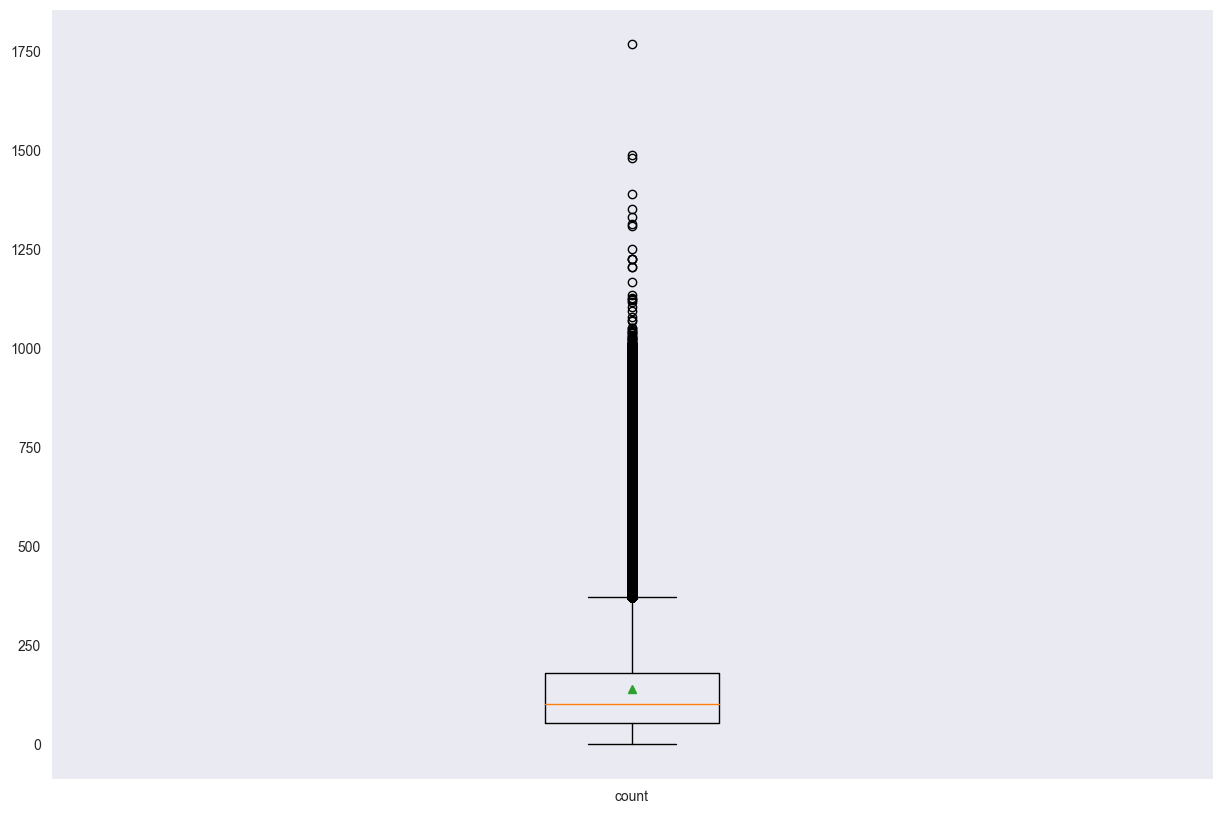

In [28]:
""" Box plot of length of text data"""

sns.set_style(style='dark')
plt.figure(figsize=(15,10))

plt.boxplot(lengths, labels=['count'], showmeans=True) 

Text(0, 0.5, 'number of texts')

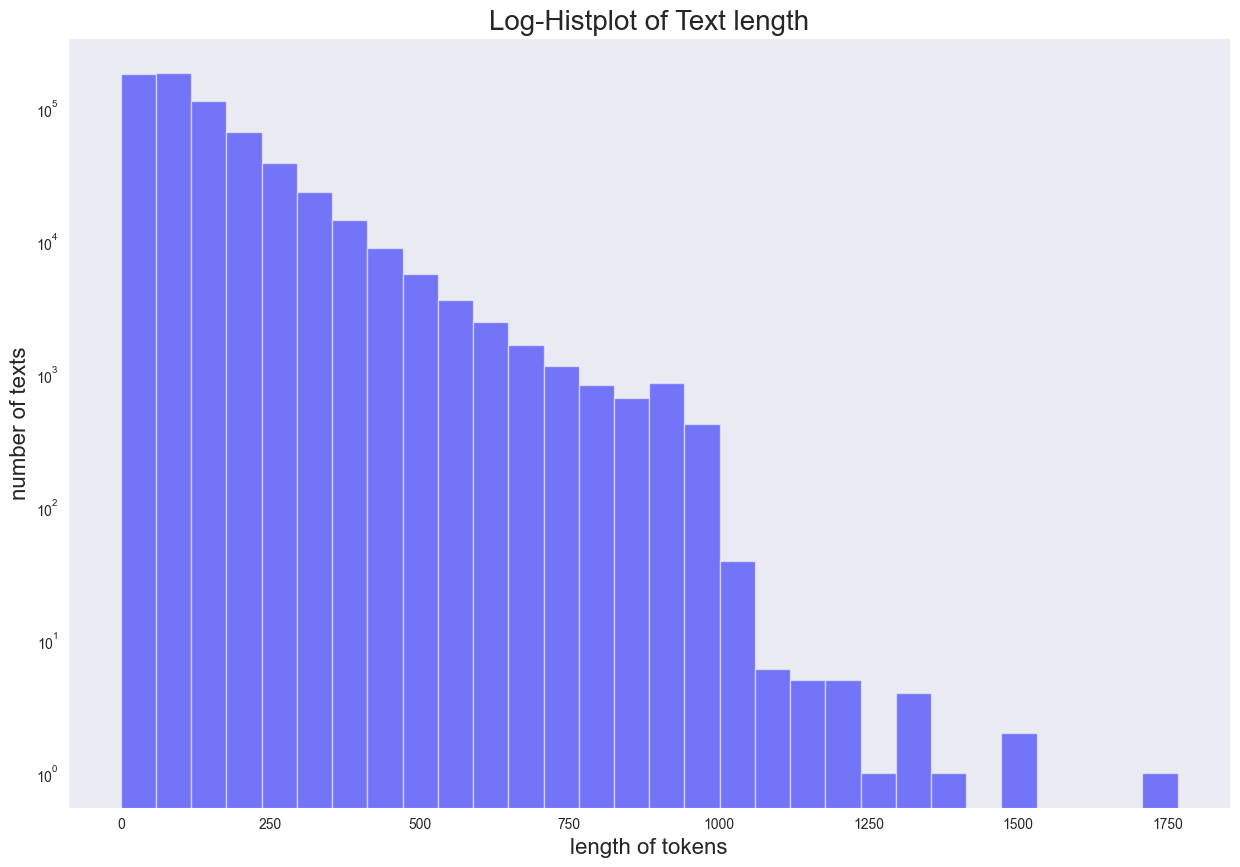

In [29]:
""" log scale hist plot """

sns.set_style(style='dark')
plt.figure(figsize=(15,10))

plt.hist(lengths, bins=30, alpha=0.5, color='blue', label='tokens')
plt.yscale('log')
plt.title("Log-Histplot of Text length", fontsize=20)
plt.xlabel("length of tokens", fontsize=16)
plt.ylabel("number of texts", fontsize=16)

(-0.5, 799.5, 599.5, -0.5)

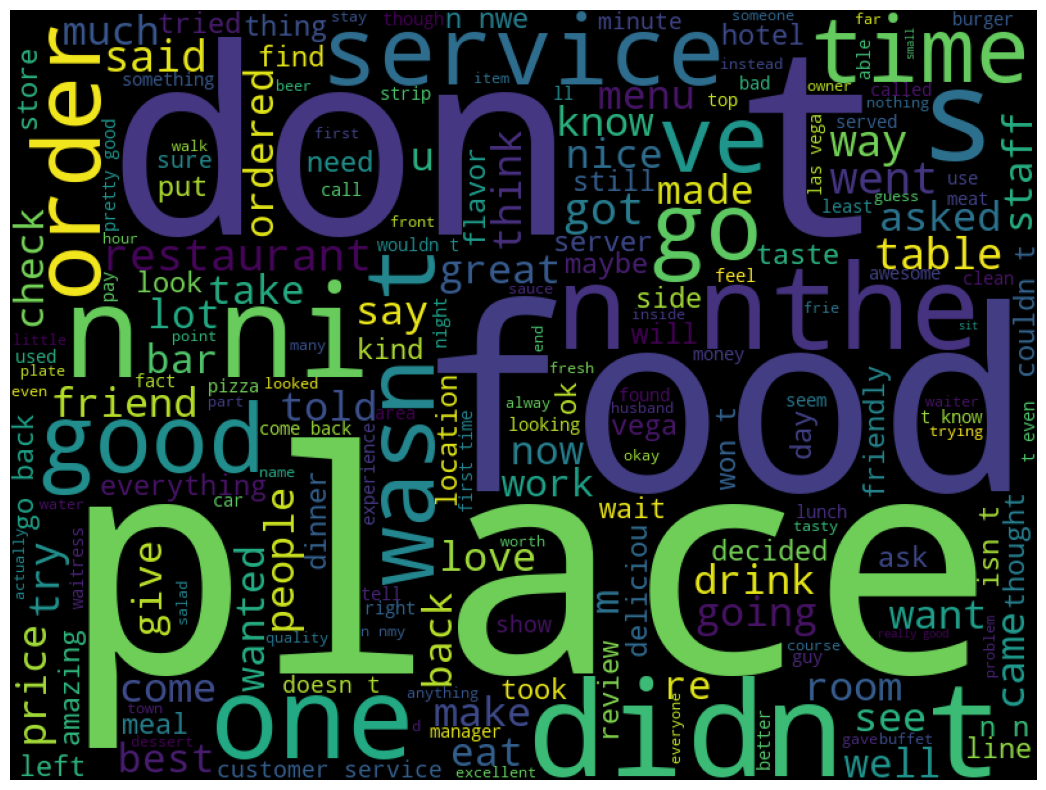

In [31]:
""" word cloud plot """

cloud = WordCloud(width=800, height=600).generate(" ".join(df['text']))
plt.figure(figsize=(15,10))
plt.imshow(cloud)
plt.axis('off') 

In [33]:
""" plot for rating distribution """

rating_count = df['label'].value_counts()
rating_count

4    130000
1    130000
3    130000
0    130000
2    130000
Name: label, dtype: int64

<AxesSubplot: >

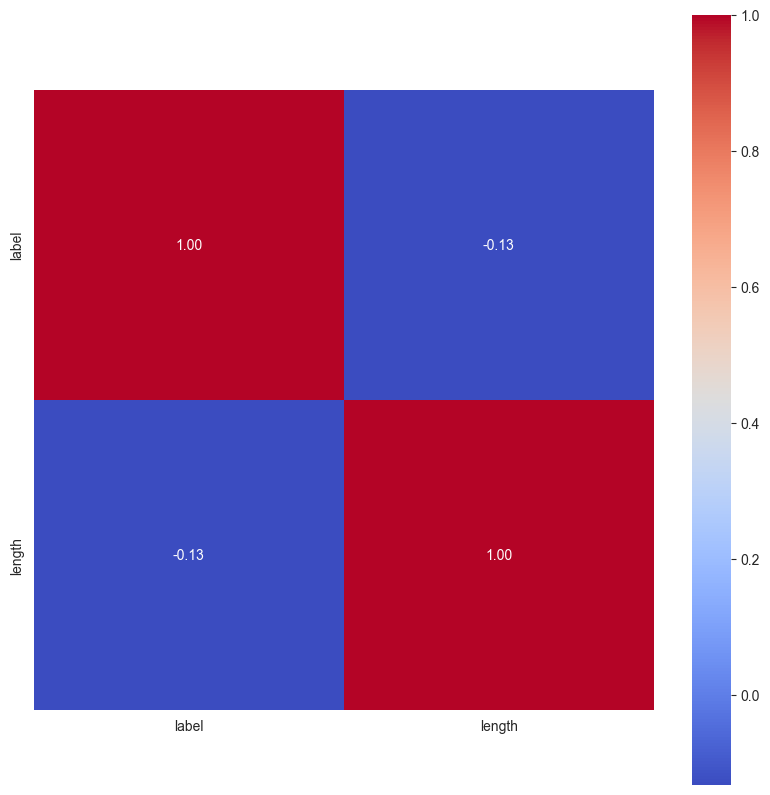

In [35]:
""" co-relation between length of review and rating """

labels = df.label.to_list()
corr_df = pd.DataFrame()
corr_df['label'], corr_df['length'] = labels, lengths
measure_corr = corr_df.corr() 

plt.figure(figsize=(10,10))
sns.heatmap(
    measure_corr, 
    xticklabels=measure_corr.columns, 
    yticklabels=measure_corr.columns, 
    square=True,
    annot=True, 
    cmap="coolwarm",
    fmt=".2f"
)

In [48]:
def jsonl_to_json(jsonl_file: str, json_file: str) -> None:
    """ Convert jsonl file to json file
    
    Args:
        jsonl_file: input jsonl file path
        json_file: output json file path, which is converted from jsonl file
        
    Examples:
        jsonl_to_json('./data_folder/amazon_review/beauty.jsonl', './data_folder/amazon_review/beauty.json')
        
    """
    with open(jsonl_file, 'r', encoding='utf-8') as f:
        jsonl_data = f.readlines()

    json_data = [json.loads(line.strip()) for line in jsonl_data]
    with open(json_file, 'w', encoding='utf-8') as f:
        json.dump(json_data, f, ensure_ascii=False, indent=4)

jsonl_to_json('./data_folder/amazon_review/beauty.jsonl', './data_folder/amazon_review/beauty.json')

In [4]:
""" Load Amazon Review Dataset """

DATA_PATH = './data_folder/'
DATA_NAME = 'amazon_review'
TYPE = 'beauty.json'

df = load_all_types_dataset(f'{DATA_PATH}{DATA_NAME}/{TYPE}')
df

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923,0,True
1,4,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.070,1,True
2,5,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052,2,True
3,1,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220,0,True
4,5,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.534,0,True
...,...,...,...,...,...,...,...,...,...,...
701523,4,Four Stars,Conditioner is great shampoo not as I expected,[],B006YUIWKA,B006YUIWKA,AFIXGFVEGLMOTMBTJL7H3VSIETDQ,2016-11-04 02:37:01.000,0,True
701524,1,Pretty,Did not work! Used the whole bottle and my hai...,[],B006YUIWKA,B006YUIWKA,AFV7YZFOJF564EZGET5LG45K4QEA,2016-12-05 03:32:10.000,0,False
701525,5,Great sunless tanner,Product as expected. Shipping was on time.,[],B06ZZV9MZT,B06ZZV9MZT,AHYDCWDMMVMLBX7FY7M7JKADKRDQ,2020-05-27 02:52:54.067,0,True
701526,5,The Crown on top is a Ring!!!,"Not only is it a delicious fragrance, but also...",[],B000HB6VLE,B000HB6VLE,AF6ZIAEN7TQ2WY5ZL77F6JDPV7XQ,2007-07-18 22:36:49.000,4,False


In [11]:
""" calculate length of each text data, check statistics value of train text data """

lengths = sequence_length(CFG, df['text'])
eda.print_length_stats_of_text(lengths)

  0%|          | 0/701528 [00:00<?, ?it/s]

------------- Length Statistic Info -------------
Max Length of Sentence : 3386
Min Length of Sentence : 0
Mean Length of Sentence : 40.15
Std Length of Sentence : 58.41
Median Length of Sentence : 24.0
Q1 Length of Sentence : 10.0
Q3 Length of Sentence : 48.0


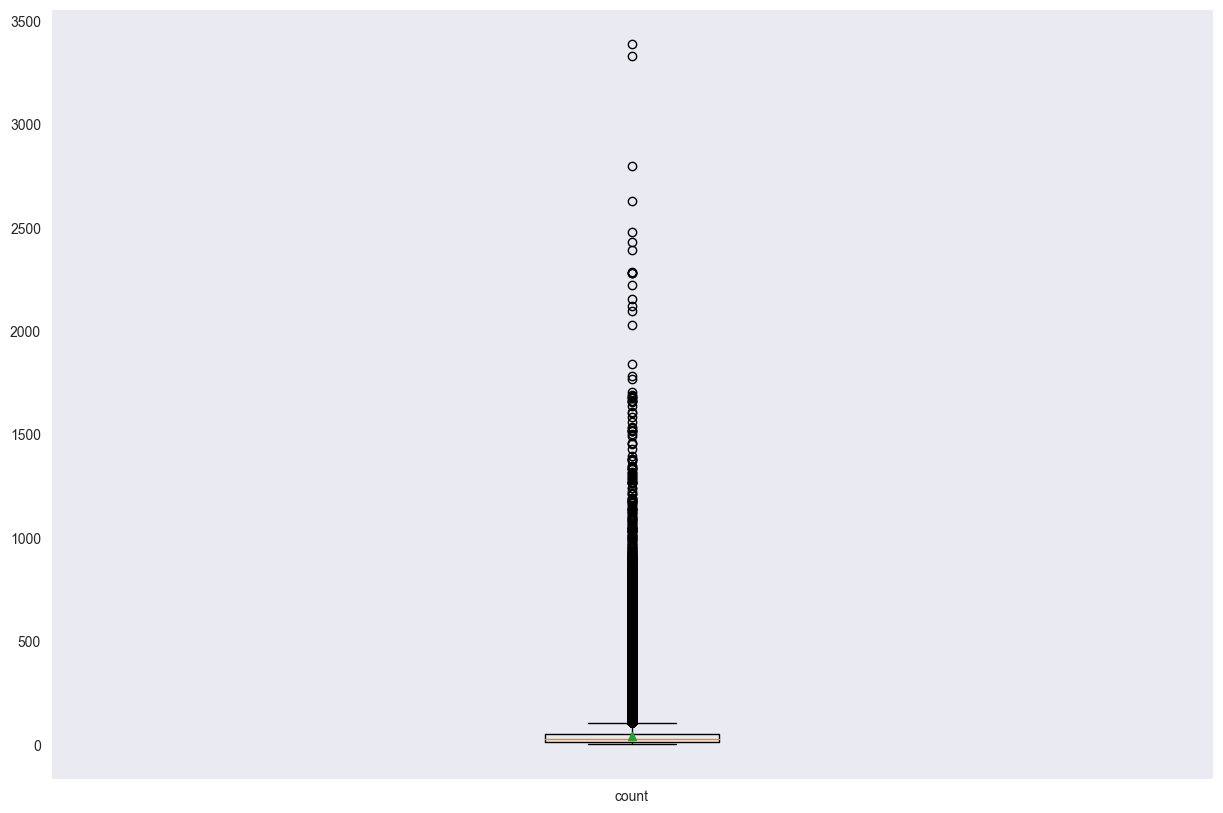

In [12]:
""" Box plot of length of text data """

eda.token_length_box_plot(lengths)

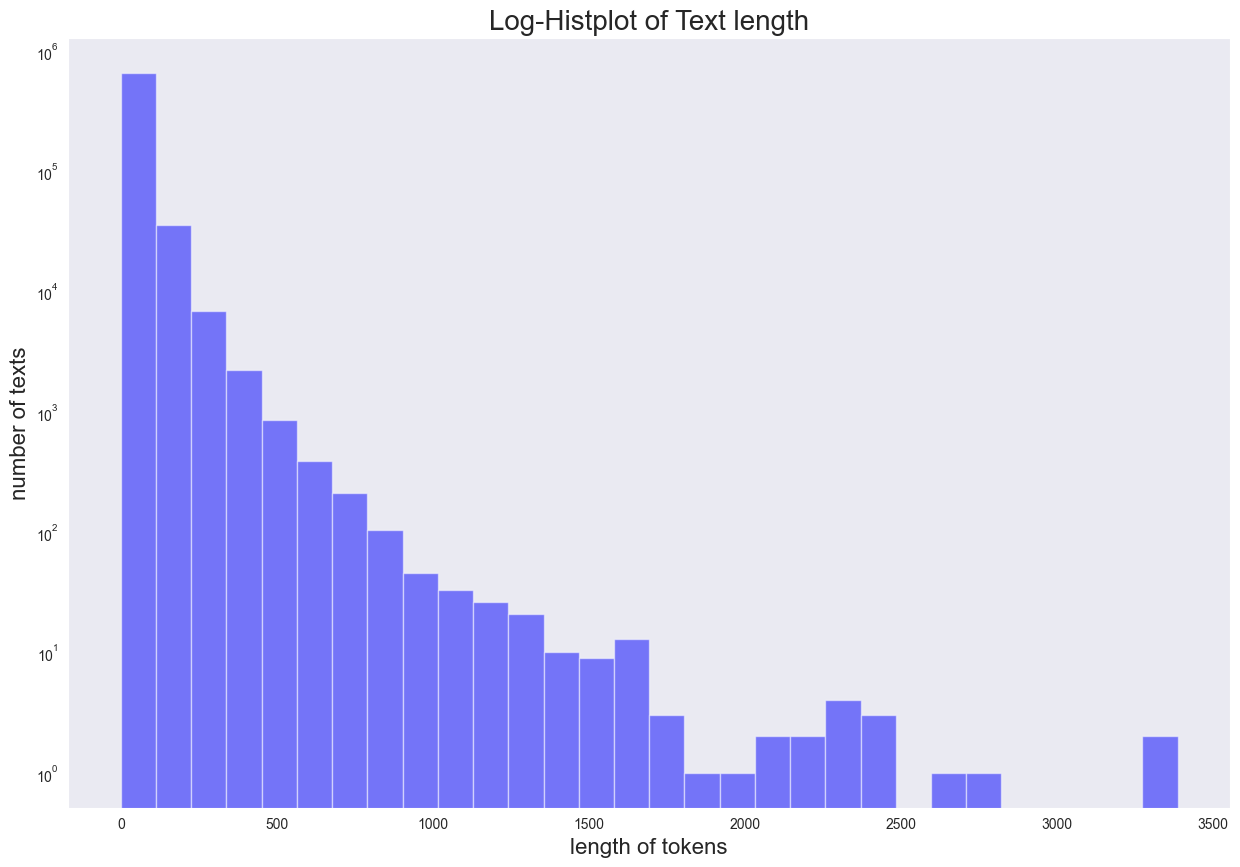

In [13]:
""" log scale hist plot """

eda.log_scale_token_length_plot(lengths)

Must use longer sequence for LLM model, because of the limitation of the maximum input length of the model
such as llama, deberta, bigbird, longformer and so on